# Deep Convolutional Neural Network for Atari


# Instalar Gymnasium

In [1]:
!pip install gymnasium
!pip install "gymnasium[atari, accept-rom-license]"
!apt-get install -y swig
!pip install gymnasium[box2d]


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip
"apt-get" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached swig-4.2.1-py2.py3-none-win_amd64.whl.metadata (3.7 kB)
Using cached swig-4.2.1-py2.py3-none-win_amd64.whl (2.6 MB)
  Running setup.py clean for box2d-py
Failed to build box2d-py


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [16 lines of output]
      Using setuptools (version 65.5.0).
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-311
      creating build\lib.win-amd64-cpython-311\Box2D
      copying library\Box2D\Box2D.py -> build\lib.win-amd64-cpython-311\Box2D
      copying library\Box2D\__init__.py -> build\lib.win-amd64-cpython-311\Box2D
      creating build\lib.win-amd64-cpython-311\Box2D\b2
      copying library\Box2D\b2\__init__.py -> build\lib.win-amd64-cpython-311\Box2D\b2
      running build_ext
      building 'Box2D._Box2D' extension
      swigging Box2D\Box2D.i to Box2D\Box2D_wrap.cpp
      swig.exe -python -c++ -IBox2D -small -O -includeall -ignoremissing -w201 -globals b2Globals -outdir library\Box2D -keyword -w511 -D_SWIG_KWARGS -o Box2D\Box2D_wrap.cpp Box2D\Box2D.i
      error: comman

# Librerías

In [2]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from collections import deque
from tensorflow.data import Dataset


# Arquitectura

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, Model

class Network(Model):
    def __init__(self, action_size, seed=42):
        super(Network, self).__init__()
        tf.random.set_seed(seed)
        self.conv1 = layers.Conv2D(32, kernel_size=8, strides=4, activation='relu', padding='same')
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(64, kernel_size=4, strides=2, activation='relu', padding='same')
        self.bn2 = layers.BatchNormalization()
        self.conv3 = layers.Conv2D(64, kernel_size=3, strides=1, activation='relu', padding='same')
        self.bn3 = layers.BatchNormalization()
        self.conv4 = layers.Conv2D(128, kernel_size=3, strides=1, activation='relu', padding='same')
        self.bn4 = layers.BatchNormalization()
        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(512, activation='relu')
        self.fc2 = layers.Dense(256, activation='relu')
        self.fc3 = layers.Dense(action_size)

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return self.fc3(x)


#  Entrenamiento

In [4]:
import gymnasium as gym
# Crea un entorno de juego usando Gymnasium, específicamente la versión determinista de Ms. Pac-Man
env = gym.make('ALE/Pacman-v5', full_action_space = False)#,  render_mode="human")

# Obtiene la forma del espacio de observación, que describe la forma de los datos de entrada (imágenes del juego)
state_shape = env.observation_space.shape

# Obtiene el tamaño de la dimensión 0 del espacio de observación, que es la altura de las imágenes del juego
state_size = env.observation_space.shape[0]

# Obtiene el número de posibles acciones que el agente puede tomar en este entorno
number_actions = env.action_space.n

print('State shape: ', state_shape)
print('State size: ', state_size)
print('Number of actions: ', number_actions)


State shape:  (250, 160, 3)
State size:  250
Number of actions:  5


# Hiperparámetros

In [5]:
learning_rate = 5e-4
minibatch_size = 64
discount_factor = 0.99

# Preprocesamiento de frame

In [6]:
import tensorflow as tf
from tensorflow.keras import layers

def preprocess_frame(frame):
    # Convertir el arreglo numpy a un tensor de TensorFlow
    frame = tf.convert_to_tensor(frame, dtype=tf.float32)

    # Redimensionar la imagen a 128x128
    frame = tf.image.resize(frame, [128, 128])

    # Normalizar los píxeles al rango [0, 1] si es necesario (asumiendo que los píxeles están en 0-255)
    frame = frame / 255.0

    # Añadir una dimensión de lote en la primera posición
    frame = tf.expand_dims(frame, axis=0)
    return frame


# Agente

In [7]:
import numpy as np
import random
from collections import deque
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

class Agent:
    def __init__(self, action_size, learning_rate=0.001, update_every=4):
        self.action_size = action_size
        self.local_qnetwork = Network(action_size)
        self.target_qnetwork = Network(action_size)
        self.optimizer = Adam(learning_rate=learning_rate)
        self.memory = deque(maxlen=10000)                   # experience replay
        self.loss_function = MeanSquaredError()
        self.losses = []
        self.t_step = 0                                     # Contador para actualizar la red objetivo
        self.update_every = update_every                    # Frecuencia de actualización de la red objetivo

        # Inicializa las redes llamándolas con un input ficticio
        dummy_input = tf.convert_to_tensor(np.zeros((1, 128, 128, 3)), dtype=tf.float32)  # Ajustar la forma según el preprocesamiento real
        self.local_qnetwork(dummy_input)
        self.target_qnetwork(dummy_input)
        
        # Inicializa la red objetivo con los mismos pesos que la red local
        self.update_target_network()

    def step(self, state, action, reward, next_state, done):
        state = preprocess_frame(state)
        next_state = preprocess_frame(next_state)
        self.memory.append((state, action, reward, next_state, done))   # Almacena la experiencia (estado, acción, recompensa, siguiente estado, terminado) en la memoria
        minibatch_size = 64                                             # Tamaño del minibatch para el aprendizaje
        loss = None

        # Si hay suficientes experiencias en la memoria, realiza un paso de aprendizaje
        if len(self.memory) > minibatch_size:
            experiences = random.sample(self.memory, k=minibatch_size)  # Toma una muestra aleatoria de experiencias de la memoria
            loss = self.learn(experiences, discount_factor=0.99)        # Realiza el aprendizaje utilizando las experiencias muestreadas
            self.losses.append(loss)  
                                              # Almacena la pérdida obtenida en la lista de pérdidas
        self.t_step += 1
        # Cada 'update_every' pasos, actualiza la red objetivo
        if self.t_step % self.update_every == 0:
            self.update_target_network()
        return loss

    def act(self, state, epsilon=0.1):
        state = preprocess_frame(state)                              # Preprocesa el estado para adecuarlo al formato esperado por la red neuronal
        state = tf.convert_to_tensor(state)
        action_values = self.local_qnetwork(state, training=False)   # Pasa el estado actual por la red Q local para obtener los valores Q para cada acción
        if random.random() > epsilon:                                # Selecciona una acción utilizando la política epsilon-greedy
            return np.argmax(action_values.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, discount_factor):
        states, actions, rewards, next_states, dones = zip(*experiences)
        # Convierte las experiencias en tensores de TensorFlow
        states = tf.convert_to_tensor(np.vstack(states), dtype=tf.float32)
        actions = tf.convert_to_tensor(np.vstack(actions), dtype=tf.int32)
        rewards = tf.convert_to_tensor(np.vstack(rewards), dtype=tf.float32)
        next_states = tf.convert_to_tensor(np.vstack(next_states), dtype=tf.float32)
        dones = tf.convert_to_tensor(np.vstack(dones).astype(np.uint8), dtype=tf.float32)

        with tf.GradientTape() as tape:
            # Double DQN: Selección de acciones con la red local y evaluación con la red objetivo
            # Obtén los valores de acción (Q-values) para los siguientes estados usando la red local
            action_values = self.local_qnetwork(next_states, training=False)
            best_actions = tf.argmax(action_values, axis=1)                                         # Selecciona las mejores acciones (aquellas con los mayores valores Q) para los siguientes estados
            next_q_targets = tf.gather_nd(self.target_qnetwork(next_states, training=False),        # Evalúa los valores Q de las mejores acciones usando la red objetivo
                                          tf.expand_dims(best_actions, axis=1), batch_dims=1)

            q_targets = rewards + discount_factor * next_q_targets * (1 - dones)                    # Calcula los valores objetivo Q                  
            q_expected = tf.gather_nd(self.local_qnetwork(states), 
                                      tf.expand_dims(actions, 1), batch_dims=1)                     # Obtén los valores Q esperados para las acciones tomadas en los estados actuales usando la red local
            loss = self.loss_function(q_targets, q_expected)                                        # Calcula la pérdida entre los valores objetivo y los valores esperados

        # Calcula los gradientes de la pérdida respecto a los parámetros de la red local
        gradients = tape.gradient(loss, self.local_qnetwork.trainable_variables)
        # Aplica los gradientes para actualizar los parámetros de la red local
        self.optimizer.apply_gradients(zip(gradients, self.local_qnetwork.trainable_variables))
        return loss.numpy()

    def update_target_network(self):
        # Actualizar los pesos de la red objetivo con los de la red local
        self.target_qnetwork.set_weights(self.local_qnetwork.get_weights())



# Inicialización

In [8]:
agent = Agent(number_actions)

# Entrenamiento de Agente

In [9]:
import numpy as np
from collections import deque
import tensorflow as tf
from tqdm import tqdm

# Configuración de hiperparámetros y variables iniciales
number_episodes = 50
maximum_number_timesteps_per_episode = 10000
epsilon_starting_value = 1
epsilon_ending_value = 0.01
epsilon_decay_value = 0.995
epsilon = epsilon_starting_value
scores_on_100_episodes = deque(maxlen=100) # Almacena los puntajes de los últimos 100 episodios
scores = []                                # Lista para almacenar los puntajes de todos los episodios
losses = []                                # Lista para almacenar las pérdidas (losses) de entrenamiento

for episode in range(1, number_episodes + 1): # por cada episodio
    state, _ = env.reset()                    # reinicia el entorno al estado inicial        
    score = 0                                 # puntaje del episodio
    episode_length = 0                        # longitud del episodio (numero de pasos)

    # configuracion de barra de progreso para cada episodio
    with tqdm(total=maximum_number_timesteps_per_episode, 
              desc=f'Episode {episode}/{number_episodes}', 
              leave=False) as pbar:
        for t in range(maximum_number_timesteps_per_episode):           # por cada paso del espisodio
            #env.render()
            action = agent.act(state, epsilon)                          # Selecciona una acción utilizando la política epsilon-greedy
            next_state, reward, done, _, _ = env.step(action)           # Ejecuta la acción en el entorno
            loss = agent.step(state, action, reward, next_state, done)  # Almacena la experiencia y aprende
            state = next_state                                          # Actualiza estado actual
            score += reward                                             # Acumula recompensa obtenida durante el episodio
            episode_length += 1
            pbar.update(1)                                              # Actualiza la barra de progreso
            if done:                                                    # Si el episodio ha terminado
                pbar.n = maximum_number_timesteps_per_episode           # Completa la barra de progreso
                pbar.refresh()                                          # Refresca la barra de progreso
                break                                                   # termina los pasos del episodio

    # Almacena el puntaje del episodio actual
    scores.append(score)
    if loss is not None:
        losses.append(loss)

    # Almacena el puntaje en la cola de los últimos 100 episodios
    scores_on_100_episodes.append(score)
    epsilon = max(epsilon_ending_value, epsilon_decay_value * epsilon)

    print(f'\rEpisode {episode}/{number_episodes} - Score: {score} - Avg Score: {np.mean(scores_on_100_episodes):.2f} - Epsilon: {epsilon:.3f} - Length: {episode_length}')
    if np.mean(scores_on_100_episodes) >= 500.0:
        print(f'\nEnvironment solved in {episode - 100} episodes!\tAverage Score: {np.mean(scores_on_100_episodes):.2f}')
        agent.local_qnetwork.save_weights('checkpoint.h5')
        break



Episode 1/50 - Score: 27.0 - Avg Score: 27.00 - Epsilon: 0.995 - Length: 448


Episode 2/50 - Score: 14.0 - Avg Score: 20.50 - Epsilon: 0.990 - Length: 412


Episode 3/50 - Score: 8.0 - Avg Score: 16.33 - Epsilon: 0.985 - Length: 322


Episode 4/50 - Score: 13.0 - Avg Score: 15.50 - Epsilon: 0.980 - Length: 434


Episode 5/50 - Score: 10.0 - Avg Score: 14.40 - Epsilon: 0.975 - Length: 408


Episode 6/50 - Score: 11.0 - Avg Score: 13.83 - Epsilon: 0.970 - Length: 412


Episode 7/50 - Score: 7.0 - Avg Score: 12.86 - Epsilon: 0.966 - Length: 324


Episode 8/50 - Score: 15.0 - Avg Score: 13.12 - Epsilon: 0.961 - Length: 362


Episode 9/50 - Score: 17.0 - Avg Score: 13.56 - Epsilon: 0.956 - Length: 416


Episode 10/50 - Score: 14.0 - Avg Score: 13.60 - Epsilon: 0.951 - Length: 368


Episode 11/50 - Score: 22.0 - Avg Score: 14.36 - Epsilon: 0.946 - Length: 416


Episode 12/50 - Score: 17.0 - Avg Score: 14.58 - Epsilon: 0.942 - Length: 416


KeyboardInterrupt: 

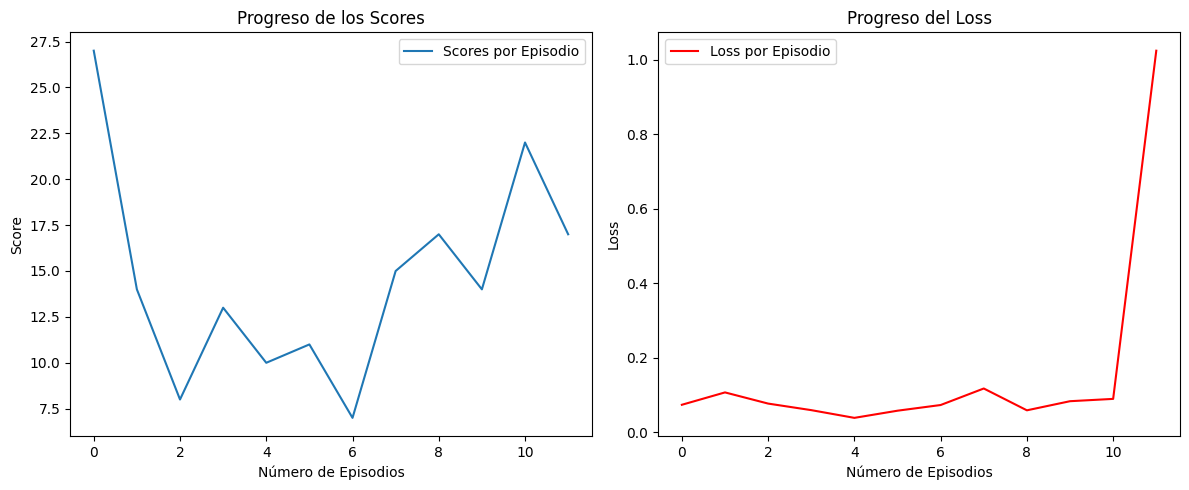

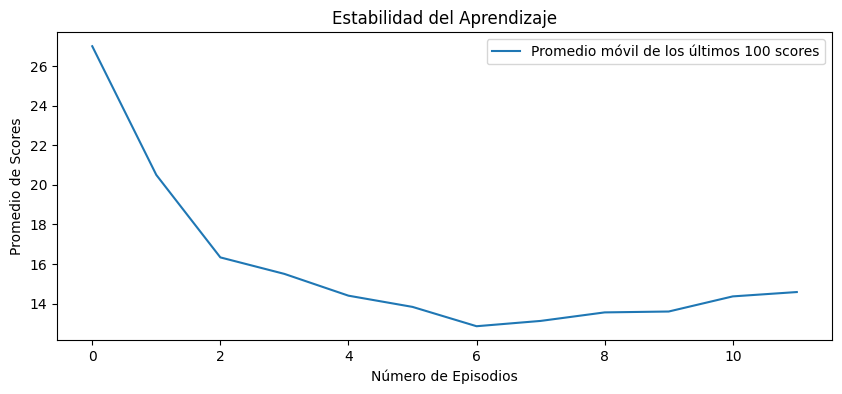

In [10]:
import matplotlib.pyplot as plt

# Graficar los Scores
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(scores, label='Scores por Episodio')
plt.title('Progreso de los Scores')
plt.xlabel('Número de Episodios')
plt.ylabel('Score')
plt.legend()

# Graficar los Losses
plt.subplot(1, 2, 2)
plt.plot(losses, label='Loss por Episodio', color='r')
plt.title('Progreso del Loss')
plt.xlabel('Número de Episodios')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Graficar el promedio de los últimos 100 scores para evaluar la estabilidad
plt.figure(figsize=(10, 4))
plt.plot([np.mean(scores[max(0, i-100):i+1]) for i in range(len(scores))], label='Promedio móvil de los últimos 100 scores')
plt.title('Estabilidad del Aprendizaje')
plt.xlabel('Número de Episodios')
plt.ylabel('Promedio de Scores')
plt.legend()
plt.show()


# Visualización de resultados

In [11]:

!pip install imageio[ffmpeg]


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
import glob
import io
import base64
import imageio
from IPython.display import HTML
import gymnasium as gym

def show_video_of_model(agent, env_name):
    env = gym.make(env_name, render_mode='rgb_array')
    state, _ = env.reset()
    done = False
    frames = []
    while not done:
        frame = env.render()
        frames.append(frame)
        action = agent.act(state, epsilon=0.00)  # Assuming a low epsilon for demonstration
        state, reward, done, _, _ = env.step(action)
    env.close()
    imageio.mimwrite('video.mp4', frames, fps=30, quality=8)  # Use mimwrite with correct parameters

def show_video():
    mp4list = glob.glob('*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

# Usage
#agent = # Asumiendo que 'agent' ya está definido
show_video_of_model(agent, 'ALE/Pacman-v5')
show_video()


In [4]:
# Lista de scores extraída de los datos proporcionados
scores = [
    4000.0, 3200.0, 5600.0, 3200.0, 3200.0, 3200.0, 3200.0, 3200.0, 1600.0, 4000.0,
    3200.0, 3200.0, 800.0, 3200.0, 4000.0, 5600.0, 1600.0, 4000.0, 1600.0, 4000.0,
    7200.0, 4000.0, 7200.0, 5600.0, 1600.0, 2400.0, 4000.0, 3200.0, 3200.0, 3200.0,
    4000.0
]

# Calcular la media
media_score = sum(scores) / len(scores)

# Mostrar el resultado
print(f"La media de los scores es: {media_score:.2f}")


La media de los scores es: 3587.10
